# **Exploratory Data Analysis**

## Objectives

* Examine the data:
  1. Understand the columns of the tabular dataset
  2. Understand the dependent variable
  3. Understand relationships between dependent and independent variables

## Inputs

Downloaded from https://www.kaggle.com/datasets/codeinstitute/housing-prices-data

* house_prices_records: main data set on which model to be trained, contains 24 columns and 1460 rows
* inherited_houses: data set on which predictions need to be performed, contains 23 columns (same as the house price records except for the dependent variable) and 4 rows
* house-metadata: data description

## Outputs

* List 

## Additional Comments

* The inputs are read from the local filesystem. Another script downloads the inputs.


# 0: Notebook Setup

###### Import libraries

In [1]:
import os
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

###### Load environment variables.

In [2]:
dotenv.load_dotenv()

True

###### File paths

In [3]:
data_dictionary_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("HOUSING_DATA_DICTIONARY"))
housing_records_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("HOUSING_RECORDS_FILENAME"))
inherited_houses_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("INHERITED_HOUSES_FILENAME"))
na_stat_housing_records_path = os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("NA_STATS_HOUSING_RECORDS_FILENAME"))

In [4]:
housing_records_rows, housing_records_columns = 1460, 24

In [5]:
plot_columns = 2

# 1: Data Understanding

# 1.0 Data Metadata

In [6]:
column_values = {}
column_descriptions = {}
column_types = {}

with open(data_dictionary_path) as file_read:
    for line in file_read:
        line = line.strip("\n")
        if not line.startswith(" ") and ":" in line:
            key, desc = line.split(":")
            column_descriptions[key] = desc
        if line.startswith(" "):
            line = line.strip(" ").strip(";")
            column_types[key] = "numerical" if "-" in line else "categorical"
            if key not in column_values:
                column_values[key] = [line]
            else:
                column_values[key].append(line)

column_types["BedroomAbvGr"] = "categorical"
for var in ["GarageYrBlt", "YearBuilt", "YearRemodAdd"]:
    column_types[var] = "temporal"

In [7]:
feature_info = pd.DataFrame(
    [(var, column_types[var], column_descriptions[var], ", ".join(values))
        for var, values  in column_values.items()],
    columns = ["featureName", "featureType", "featureDescription", "featureValues"]
)

feature_info

,featureName,featureType,featureDescription,featureValues
0,1stFlrSF,numerical,First Floor square feet,334 - 4692
1,2ndFlrSF,numerical,Second floor square feet,0 - 2065
2,BedroomAbvGr,categorical,Bedrooms above grade (does NOT include baseme...,0 - 8
3,BsmtExposure,categorical,Refers to walkout or garden level walls,"Gd: Good Exposure, Av: Average Exposure, Mn: M..."
4,BsmtFinType1,categorical,Rating of basement finished area,"GLQ: Good Living Quarters, ALQ: Average Living..."
5,BsmtFinSF1,numerical,Type 1 finished square feet,0 - 5644
6,BsmtUnfSF,numerical,Unfinished square feet of basement area,0 - 2336
7,TotalBsmtSF,numerical,Total square feet of basement area,0 - 6110
8,GarageArea,numerical,Size of garage in square feet,0 - 1418
9,GarageFinish,categorical,Interior finish of the garage,"Fin: Finished, RFn: Rough Finished, Unf: Unfin..."


In [8]:
feature_info.to_csv(os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("VARIABLE_FILES")), index=False)

In [9]:
categorical_columns = list(feature_info[feature_info["featureType"] == "categorical"]["featureName"])
numerical_columns = list(feature_info[feature_info["featureType"] == "numerical"]["featureName"])
temporal_columns = list(feature_info[feature_info["featureType"] == "temporal"]["featureName"])

## 1.1 Housing Records dataset

In [10]:
housing_records = pd.read_csv(housing_records_path)
assert housing_records.shape == (housing_records_rows, housing_records_columns)

### 1.1 Missing values

In [11]:
na_data = pd.read_csv(na_stat_housing_records_path)
display(na_data)

,column,count,percentage,should_remove
0,EnclosedPorch,1324,90.68,True
1,WoodDeckSF,1305,89.38,True
2,LotFrontage,259,17.74,True
3,GarageFinish,235,16.10,True
4,BsmtFinType1,145,9.93,False
5,BedroomAbvGr,99,6.78,False
6,2ndFlrSF,86,5.89,False
7,GarageYrBlt,81,5.55,False
8,BsmtExposure,38,2.60,False
9,MasVnrArea,8,0.55,False


In [12]:
columns_missing_data = set(na_data[na_data["should_remove"]]["column"])
columns_to_keep = housing_records.columns.difference(columns_missing_data)
numerical_columns = set(numerical_columns).difference(columns_missing_data)
categorical_columns = set(categorical_columns).difference(columns_missing_data)
temporal_columns = set(temporal_columns).difference(columns_missing_data)

In [13]:
housing_records = housing_records[columns_to_keep]
assert housing_records.shape == (housing_records_rows, housing_records_columns - len(columns_missing_data))

In [14]:
separator = 6
for _ in range(4):
    print(housing_records[housing_records.columns[_ * separator:(_+1) * separator]].head(5))
    print()

   1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1
0       856     854.0           3.0           No         706          GLQ
1      1262       0.0           3.0           Gd         978          ALQ
2       920     866.0           3.0           Mn         486          GLQ
3       961       NaN           NaN           No         216          ALQ
4      1145       NaN           4.0           Av         655          GLQ

   BsmtUnfSF  GarageArea  GarageYrBlt  GrLivArea KitchenQual  LotArea
0        150         548       2003.0       1710          Gd     8450
1        284         460       1976.0       1262          TA     9600
2        434         608       2001.0       1786          Gd    11250
3        540         642       1998.0       1717          Gd     9550
4        490         836       2000.0       2198          Gd    14260

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  SalePrice  TotalBsmtSF
0       196.0           61            5            7     

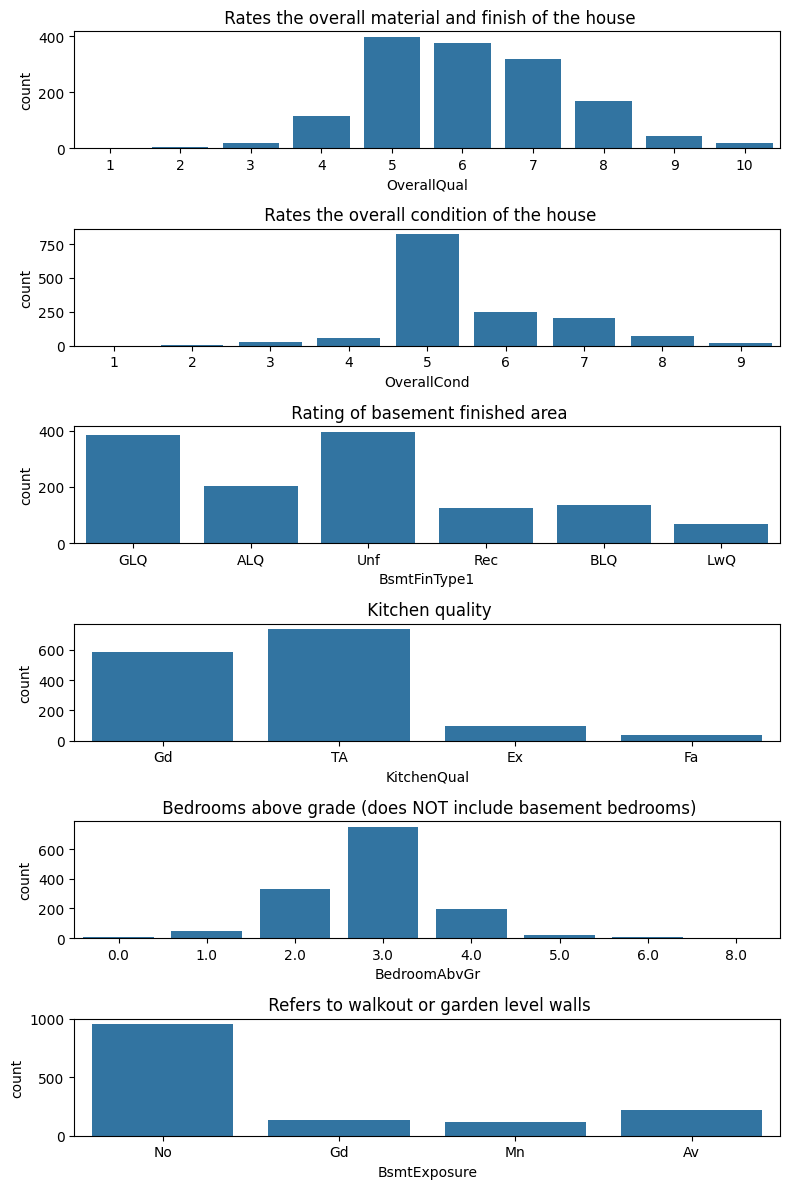

In [15]:
fig, axs = plt.subplots(int(len(categorical_columns)), figsize = (8, 2 * len(categorical_columns)))

for idx, var in enumerate(categorical_columns):
    ax = axs[idx]
    sns.countplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_xlabel(var)

plt.tight_layout()
plt.show()

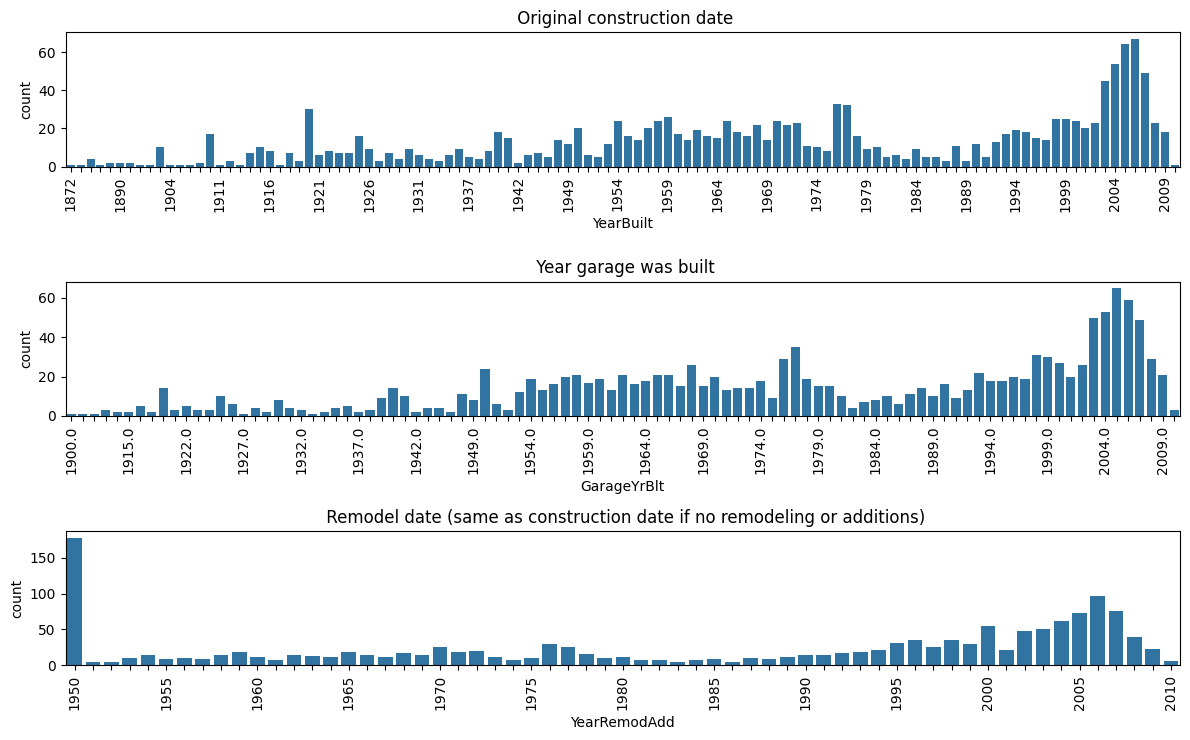

In [16]:
fig, axs = plt.subplots(int(len(temporal_columns)), figsize = (12, 2.5 * int(len(temporal_columns))))
every_nth_year = 5

for idx, var in enumerate(temporal_columns):
    ax = axs[idx]
    sns.countplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_xlabel(var)
    ax.tick_params(axis='x', rotation=90)
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth_year != 0:
            label.set_visible(False)

plt.tight_layout()
plt.show()

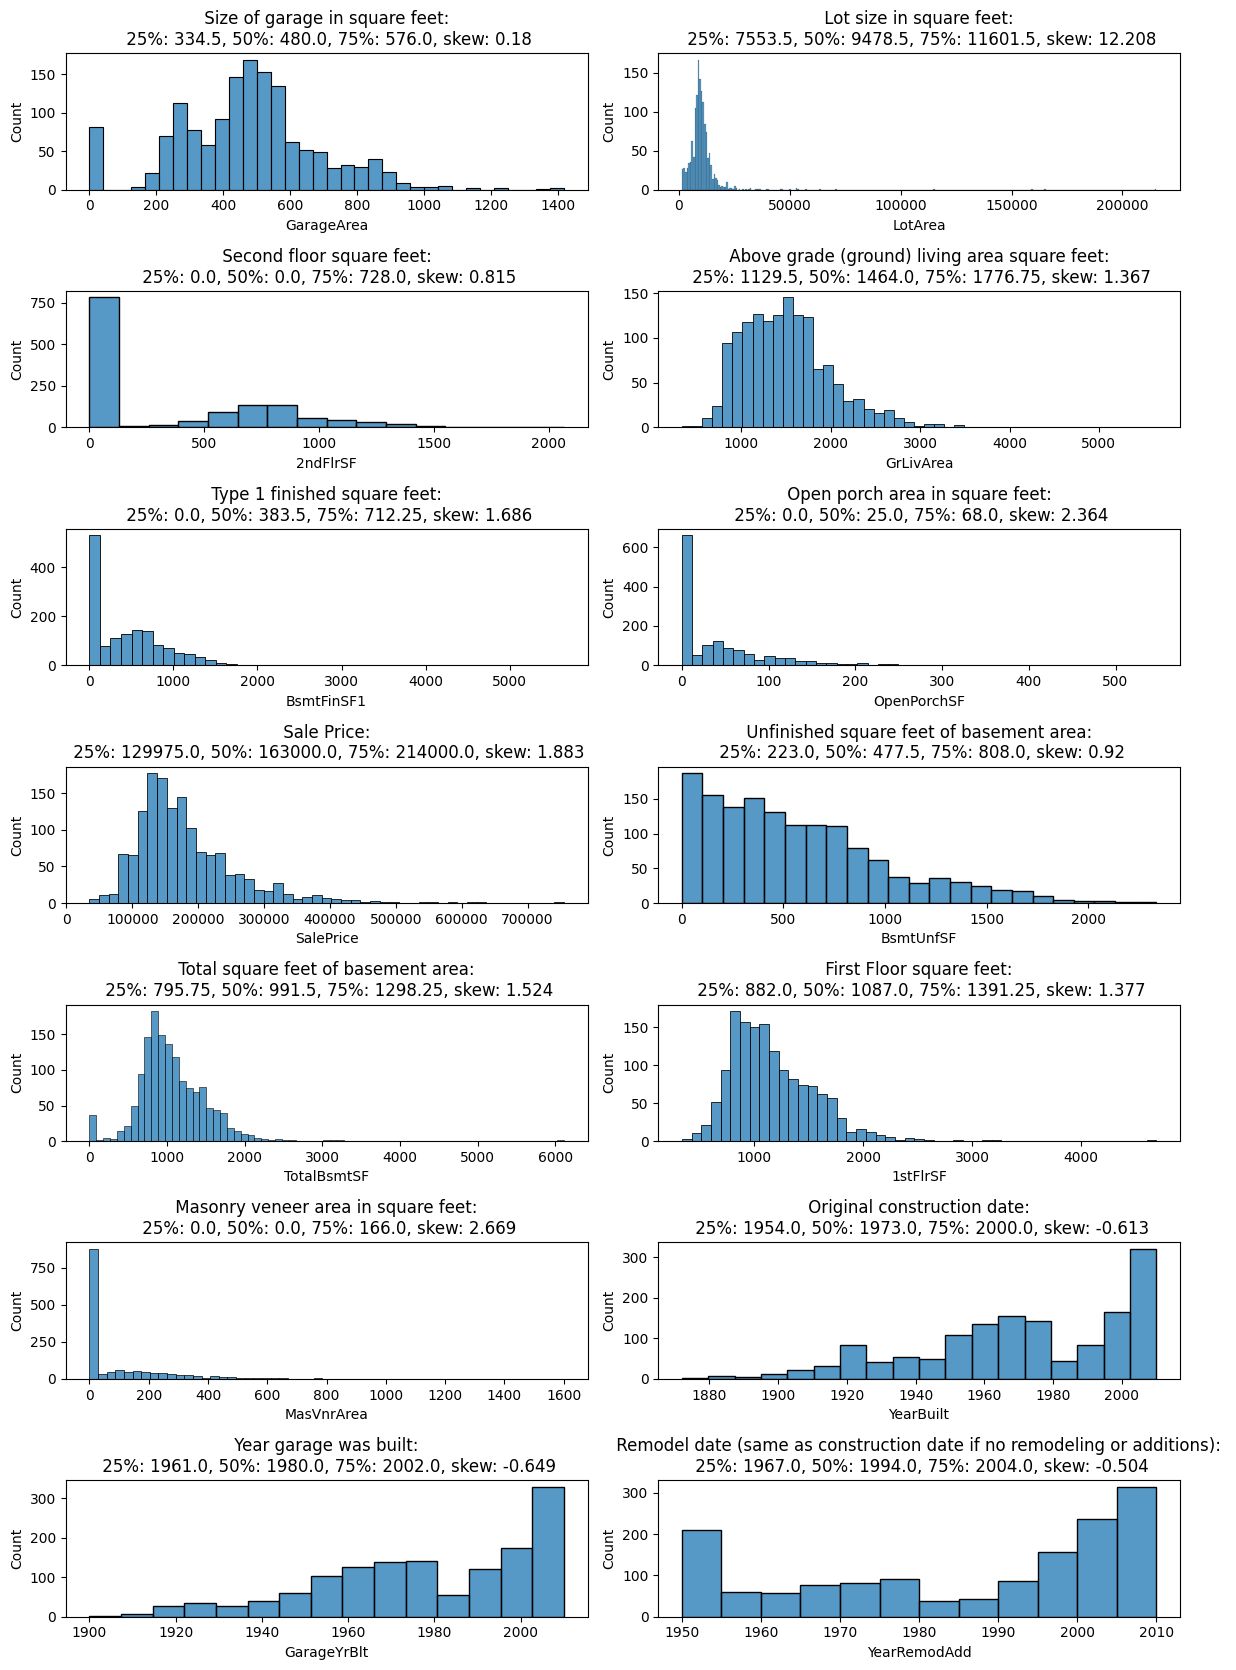

In [17]:
non_categorical_columns = list(numerical_columns) + list(temporal_columns)
column_count = int(len(non_categorical_columns))
if column_count % 2 == 1:
    column_count = column_count + 1

fig, axs = plt.subplots(int(column_count/plot_columns), plot_columns, figsize = (12, 1.2 * column_count))

for idx, var in enumerate(non_categorical_columns):
    ax = axs[int(idx / plot_columns)][idx % plot_columns]
    stats = housing_records[var].describe().loc[["25%", "50%", "75%"]]
    stats.loc["skew"] = round(housing_records[var].skew(), 3)
    sns.histplot(data=housing_records, x=var, ax=ax)
    ax.set_title(f"{column_descriptions[var]}: \n {str(stats.to_dict()).strip("{").strip("}").replace("'","")}")
    ax.set_xlabel(var)

plt.tight_layout()
plt.show()

## 1.1 Inherited houses dataset

In [18]:
inherited_houses = pd.read_csv(inherited_houses_path)
assert inherited_houses.shape == (4, 23)
inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


In [19]:
inherited_houses.columns

Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')

## 1.4 Target Variable

In [20]:
target_variable = set(housing_records.columns).difference(set(inherited_houses.columns)).pop()
target_variable

'SalePrice'

# 2: Univariate Analysis

## 2.1: Analysis of `SalePrice`

In [21]:
sale_prices = housing_records[target_variable]

In [22]:
sale_prices.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

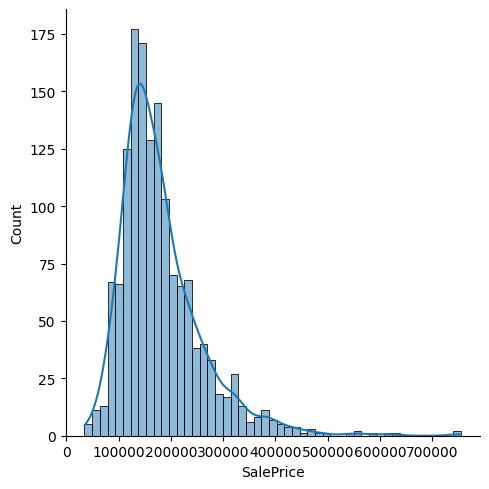

In [23]:
sns.displot(sale_prices, kde=True)

Skewness and Kurtosis

In [24]:
f"Skewness: {sale_prices.skew()}, Kurtosis: {sale_prices.kurt()}" 

'Skewness: 1.8828757597682129, Kurtosis: 6.536281860064529'

## 2.2 Co-variance of SalePrice with Numerical variables

In [25]:
def get_correlations(target_values, variating_values, target_variable, variating_name):
    corr = pd.concat([target_values, variating_values], axis=1).corr()
    corr_value = corr[variating_name].iloc[0]
    if corr.isnull().sum().sum() > 0:
        corr_description = "no correlation"
    elif var == target_variable:
        corr_description = "not applicable"
        corr_value = 1.0
    else:
        if corr_value < 0.3:
            corr_description = "very weak correlation"
        elif 0.3 <= corr_value < 0.5:
            corr_description = "weak correlation"
        elif 0.5 <= corr_value < 0.7:
            corr_description = "moderate correlation"
        else:
            corr_description = "strong correlation"
    
    return corr_value, corr_description

In [26]:
non_categorical_columns_wo_target = set(non_categorical_columns).difference(set(target_variable))
non_categorical_columns_wo_target_count = len(non_categorical_columns_wo_target)

In [27]:
correlation_data = []
for idx, var in enumerate(non_categorical_columns_wo_target):
    corr_value, corr_description = get_correlations(target_values=sale_prices, 
                                                    variating_values=housing_records[var], 
                                                    target_variable=target_variable, 
                                                    variating_name=var)
    
    
    correlation_data.append([var, corr_value, corr_description]) 

correlation_info = {
    var: [value, desc]
    for var, value, desc in sorted(correlation_data, key=lambda item: item[1], reverse=True)    
}
correlation_info

{'SalePrice': [1.0, 'not applicable'],
 'GrLivArea': [0.7086244776126517, 'strong correlation'],
 'GarageArea': [0.6234314389183622, 'moderate correlation'],
 'TotalBsmtSF': [0.6135805515591942, 'moderate correlation'],
 '1stFlrSF': [0.6058521846919153, 'moderate correlation'],
 'YearBuilt': [0.522897332879497, 'moderate correlation'],
 'YearRemodAdd': [0.5071009671113869, 'moderate correlation'],
 'GarageYrBlt': [0.48636167748785925, 'weak correlation'],
 'MasVnrArea': [0.47749304709571455, 'weak correlation'],
 'BsmtFinSF1': [0.38641980624215344, 'weak correlation'],
 '2ndFlrSF': [0.3223353146677458, 'weak correlation'],
 'OpenPorchSF': [0.31585622711605504, 'weak correlation'],
 'LotArea': [0.2638433538714051, 'very weak correlation'],
 'BsmtUnfSF': [0.21447910554696925, 'very weak correlation']}

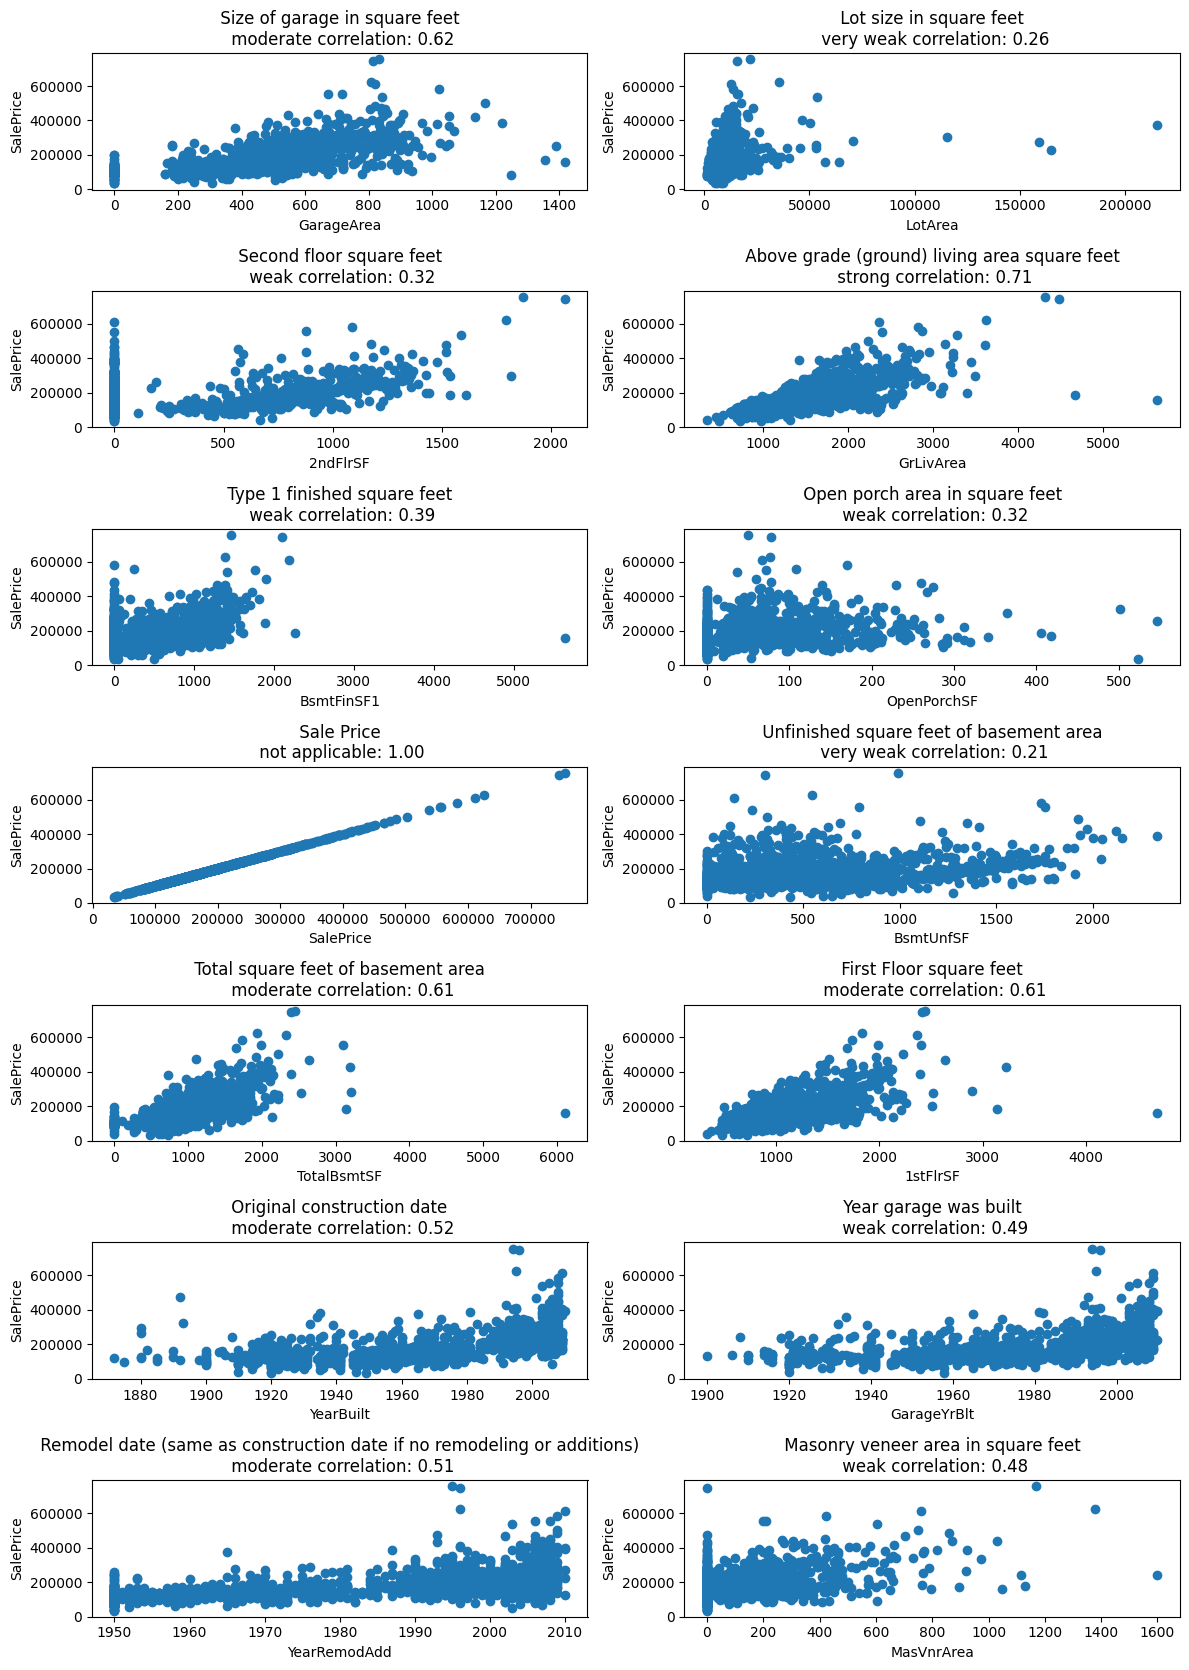

In [36]:
plot_rows = int(non_categorical_columns_wo_target_count/ plot_columns) \
    + (non_categorical_columns_wo_target_count % plot_columns)

fig, axs = plt.subplots(plot_rows, plot_columns, figsize = (12, 1.2 * non_categorical_columns_wo_target_count))
for idx, var in enumerate(non_categorical_columns_wo_target):
    ax = axs[int(idx/plot_columns)][idx%plot_columns]
    ax.scatter(housing_records[var], sale_prices)
    corr_value, corr_description = correlation_info[var]
    ax.set_title(f"{column_descriptions[var]} \n {corr_description}: {corr_value:.2f}")
    ax.set_ylabel(target_variable)
    ax.set_xlabel(var)
    
plt.tight_layout()
plt.show()

In [29]:
target_variable

'SalePrice'

In [30]:
correlated_numerical_variables = []
for key, (score, desc) in correlation_info.items():
    if score >= 0.5 and (key != target_variable):
        correlated_numerical_variables.append(key)
            
correlated_numerical_variables

['GrLivArea',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearBuilt',
 'YearRemodAdd']

## 2.3 Co-variance of SalePrice with categorical variables

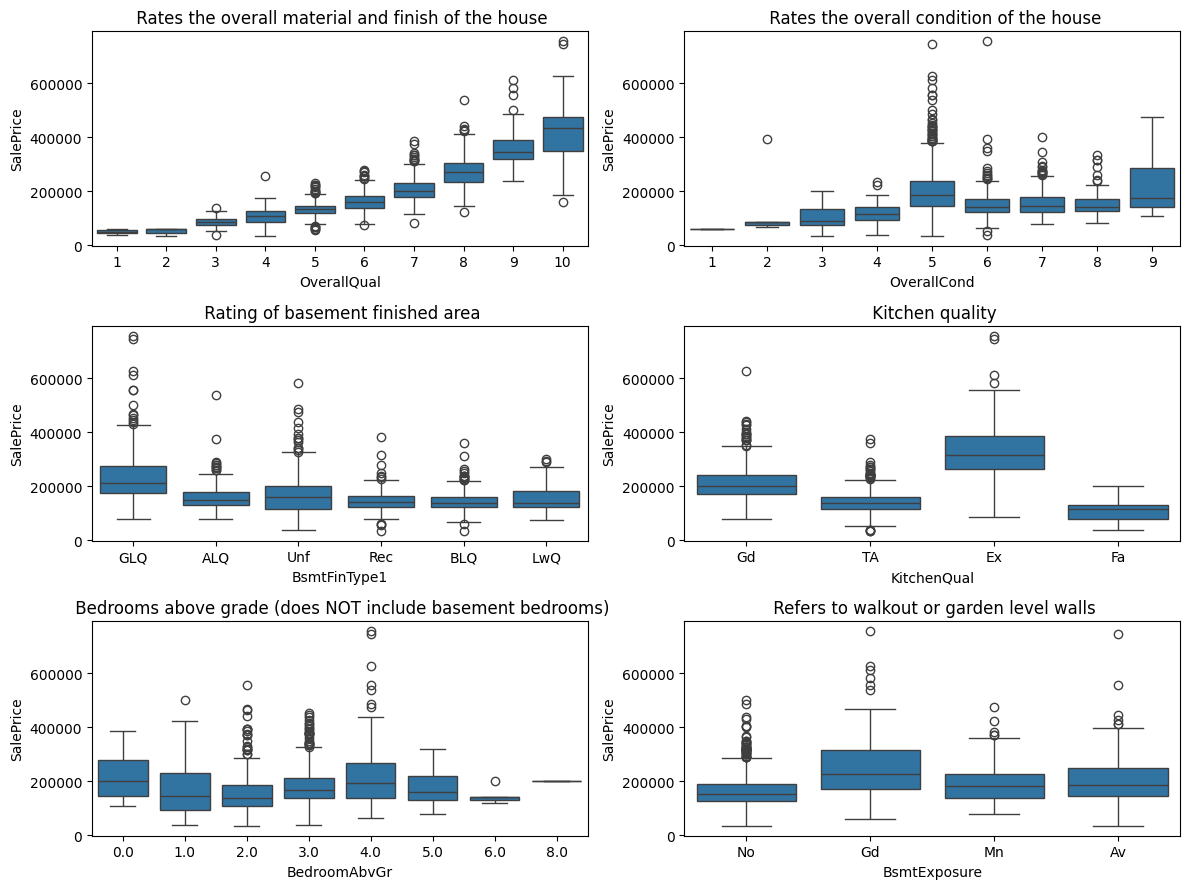

In [31]:
categorical_column_count = len(categorical_columns)
plot_rows = int(categorical_column_count / plot_columns) + (categorical_column_count % plot_columns)

fig, axs = plt.subplots(plot_rows, plot_columns, figsize = (12, 1.5 * categorical_column_count))
for idx, var in enumerate(categorical_columns):
    ax = axs[int(idx / 2)][idx % 2]
    sns.boxplot(ax=ax, x=housing_records[var], y=sale_prices)
    ax.set_title(f"{column_descriptions[var]}")
    ax.set_ylabel(target_variable)
    ax.set_xlabel(var)
    
plt.tight_layout()
plt.show()

Visually analysing the categorical data against category data definitions, 
one can conclude that "KitchenQual", "OverallCond", and "OverallQual" correlates strongly to target variable "SalePrice"

In [32]:
correlated_categorical_variables = ["KitchenQual", "OverallCond", "OverallQual"]

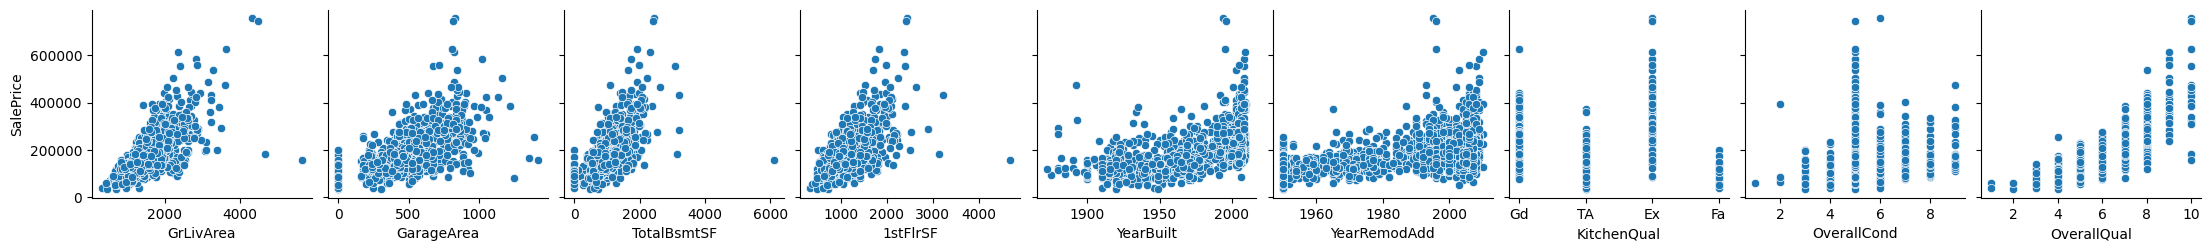

In [33]:
correlated_variables = correlated_numerical_variables + correlated_categorical_variables

sns.pairplot(
    data=housing_records,
    y_vars="SalePrice",
    x_vars=correlated_variables
)
plt.show()

In [34]:
correlated_features = feature_info[feature_info["featureName"].isin(correlated_variables)]\
    .reset_index(drop=True)
correlated_features

,featureName,featureType,featureDescription,featureValues
0,1stFlrSF,numerical,First Floor square feet,334 - 4692
1,TotalBsmtSF,numerical,Total square feet of basement area,0 - 6110
2,GarageArea,numerical,Size of garage in square feet,0 - 1418
3,GrLivArea,numerical,Above grade (ground) living area square feet,334 - 5642
4,KitchenQual,categorical,Kitchen quality,"Ex: Excellent, Gd: Good, TA: Typical/Average, ..."
5,OverallCond,categorical,Rates the overall condition of the house,"10: Very Excellent, 9: Excellent, 8: Very Good..."
6,OverallQual,categorical,Rates the overall material and finish of the ...,"10: Very Excellent, 9: Excellent, 8: Very Good..."
7,YearBuilt,temporal,Original construction date,1872 - 2010
8,YearRemodAdd,temporal,Remodel date (same as construction date if no...,1950 - 2010


In [35]:
correlated_features.to_csv(os.path.join(os.getenv("LOCAL_DATASET_PATH"), os.getenv("CORRELATED_VARIABLE_FILES")), index=False)